In [2]:
!pip install transformers
!pip install psycopg2-binary

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import tensorflow 
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
import psycopg2
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn import model_selection
import seaborn as sbn
import matplotlib.pyplot as plt

In [4]:
def get_df(db_url) -> pd.DataFrame:
    conn = psycopg2.connect(db_url)
    curs = conn.cursor()
    curs.execute("SELECT * FROM training;")
    cols = [k[0] for k in curs.description]
    rows = curs.fetchall()
    df = pd.DataFrame(rows, columns=cols)
    curs.close()
    conn.close()
    return df

In [5]:
df = get_df(db_url)
df

,id,tweets,labels
0,6,A New Mexico State Police officer killed two p...,5
1,7,I found some police badge stickers at work and...,0
2,8,"According to media reports, police said they a...",1
3,9,The male who has the knife is now running nort...,0
4,10,Changing the assignments of already existing c...,0
...,...,...,...
6025,6031,Now the case is not in hands of penguin’s poli...,5
6026,6032,Gordon Rauch died after deputies tasered him a...,5
6027,6033,I fully condemn the police brutality at the fr...,2
6028,6034,Canadian socialite charged with manslaughter o...,5


In [11]:
train = df[:5000]

In [7]:
test = df[5000:]

In [8]:
test

,id,tweets,labels
5000,4994,Video shows sound cannon deployed alongside AP...,4
5001,4995,BRING THIS MAN BEFORE CONGRESS ASAP The Man Wh...,0
5002,4996,Five people killed in London over Bank Holiday...,0
5003,4997,"AREA CHECK at 2800 NE 11TH AVE, PORT [Portland...",0
5004,4998,On the occasion of PM #Narendramodi led NDA go...,0
...,...,...,...
6025,6031,Now the case is not in hands of penguin’s poli...,5
6026,6032,Gordon Rauch died after deputies tasered him a...,5
6027,6033,I fully condemn the police brutality at the fr...,2
6028,6034,Canadian socialite charged with manslaughter o...,5


In [12]:
train.to_csv('training.csv')
test.to_csv('test.csv')

In [10]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification


class FrankenBert:
    """
    Implements BertForSequenceClassification and BertTokenizer
    for binary classification from a saved model
    """

    def __init__(self, path: str):
        """
        If there's a GPU available, tell PyTorch to use the GPU.
        Loads model and tokenizer from saved model directory (path)
        """
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.model.to(self.device)

    def predict(self, text: str):
        """
        Makes a binary classification prediction based on saved model
        """
        inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=280,
            return_tensors='pt',
        ).to(self.device)
        output = self.model(**inputs)
        prediction = output[0].softmax(1)
        tensors = prediction.detach().cpu().numpy()
        result = np.argmax(tensors)
        confidence = tensors[0][result]
        return result

In [11]:
model = FrankenBert('saved_model')

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
y_true = test["labels"]

In [14]:
y_true

5000    4
5001    0
5002    0
5003    0
5004    0
       ..
6025    5
6026    5
6027    2
6028    5
6029    5
Name: labels, Length: 1030, dtype: int64

In [15]:
data = test["tweets"]

In [16]:
data

5000    Video shows sound cannon deployed alongside AP...
5001    BRING THIS MAN BEFORE CONGRESS ASAP The Man Wh...
5002    Five people killed in London over Bank Holiday...
5003    AREA CHECK at 2800 NE 11TH AVE, PORT [Portland...
5004    On the occasion of PM #Narendramodi led NDA go...
                              ...                        
6025    Now the case is not in hands of penguin’s poli...
6026    Gordon Rauch died after deputies tasered him a...
6027    I fully condemn the police brutality at the fr...
6028    Canadian socialite charged with manslaughter o...
6029    #Breaking: Several people were injured in a Mi...
Name: tweets, Length: 1030, dtype: object

In [17]:
li = []
for i in data:
    y_pred = model.predict(i)
    li.append(y_pred)

In [18]:
li[:10]

[4, 0, 0, 0, 0, 3, 0, 0, 5, 1]

In [19]:
y_true[:10]

5000    4
5001    0
5002    0
5003    0
5004    0
5005    2
5006    0
5007    0
5008    5
5009    1
Name: labels, dtype: int64

### Statistical Evaluations ###


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (2).

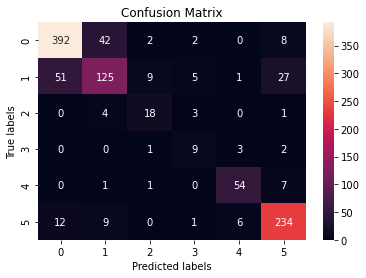

In [70]:
cm = confusion_matrix(y_true, li)
ax= plt.subplot()
sbn.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

In [21]:
f1_score(y_true, li, average='weighted')

0.8048863310738397

In [22]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
print(classification_report(y_true, li, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.86      0.88      0.87       446
     class 1       0.69      0.57      0.63       218
     class 2       0.58      0.69      0.63        26
     class 3       0.45      0.60      0.51        15
     class 4       0.84      0.86      0.85        63
     class 5       0.84      0.89      0.87       262

    accuracy                           0.81      1030
   macro avg       0.71      0.75      0.73      1030
weighted avg       0.81      0.81      0.80      1030



<AxesSubplot:xlabel='labels', ylabel='Probability'>

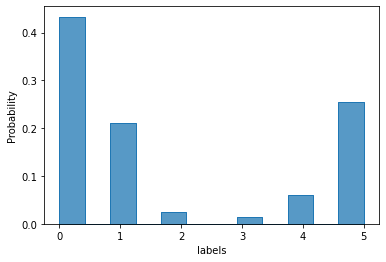

In [53]:
sbn.histplot(y_true, stat="probability", element="step")

In [24]:
train["labels"]

0       5
1       0
2       1
3       0
4       0
       ..
5495    4
5496    0
5497    5
5498    0
5499    1
Name: labels, Length: 5500, dtype: int64

<AxesSubplot:xlabel='labels', ylabel='Probability'>

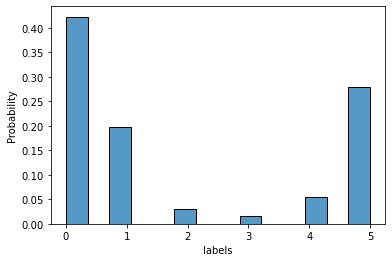

In [25]:
sbn.histplot(train["labels"], stat="probability")

<AxesSubplot:xlabel='labels', ylabel='Count'>

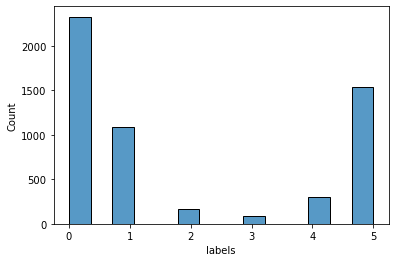

In [71]:
sbn.histplot(train["labels"])

In [26]:
recla_li = []
for i in li:
    if i <= 1:
        recla_li.append(0)
    else:
        recla_li.append(1)



In [27]:
recla_true = []
for i in y_true:
    if i <= 1:
        recla_true.append(0)
    else:
        recla_true.append(1)

In [28]:
target_names = ['Non-violent', 'Violent']
print(classification_report(recla_true, recla_li, target_names=target_names))

              precision    recall  f1-score   support

 Non-violent       0.96      0.92      0.94       664
     Violent       0.86      0.93      0.89       366

    accuracy                           0.92      1030
   macro avg       0.91      0.92      0.92      1030
weighted avg       0.92      0.92      0.92      1030



<AxesSubplot:ylabel='Probability'>

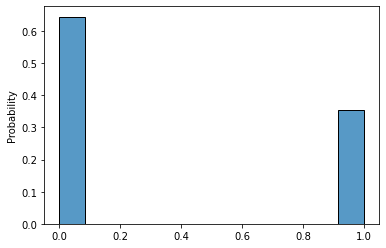

In [44]:
sbn.histplot(recla_true, stat="probability")

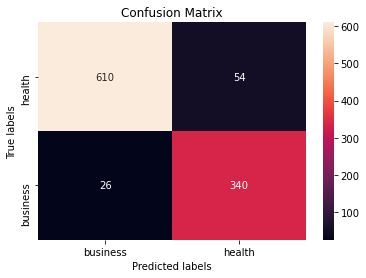

In [65]:
cm = confusion_matrix(recla_true, recla_li)
ax= plt.subplot()
sbn.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

In [30]:
model.predict("Cops gave me a speeding ticket for walking too fast")

1

In [31]:
model.predict("The cops showed up but didn't do anything")

1

In [32]:
model.predict("Cops held that guy with a neck hold")

2

In [33]:
model.predict("Cops punched me and pushed me to the ground")

3

In [34]:
model.predict("Cops hit her with a baton")

3

In [35]:
model.predict("Cops sprayed my mom with pepper spray")

4

In [36]:
model.predict("Cops shot rubber bullets at the crowd")

5

In [37]:
model.predict("Police used tear gas on a pedestrian for no reason")

4

In [38]:
model.predict("Cops killed that women")

0

In [39]:
model.predict("Yesterday I saw a policeman hit a poor person behind my house. I wonder whats going on")

3

In [40]:
model.predict("Man ran up to me and pepper sprayed me. I've called the cops, but they have not gotten themselves involved yet.")

4